In [2]:
import torch as t
from utils import DataManager
import random
import matplotlib.pyplot as plt
import random
from probes import LRProbe, MMProbe, CCSProbe
import configparser
import json

Matplotlib created a temporary cache directory at /tmp/matplotlib-yfuedtow because the default path (/share/u/smarks/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# hyperparameters
model = 'llama-2-13b'
split = 0.8
device = 'cuda:0' if t.cuda.is_available() else 'cpu'

config = configparser.ConfigParser()
config.read('config.ini')
layer = eval(config[model]['probe_layer'])
noperiod = eval(config[model]['noperiod'])

# Reproducing generalization matrix

In [4]:
train_medlies  = [
    ['cities'],
    ['cities', 'neg_cities'],
    ['larger_than'],
    ['larger_than', 'smaller_than'],
    ['likely']
]

val_datasets = [
    'cities',
    'neg_cities',
    'larger_than',
    'smaller_than',
    'sp_en_trans',
    'neg_sp_en_trans',
    'cities_cities_conj',
    'cities_cities_disj',
    'companies_true_false',
    'common_claim_true_false',
    'counterfact_true_false'    
]

def to_str(l):
    return '+'.join(l)

seed = random.randint(0, 10000)

In [31]:
ProbeClasses = [
    LRProbe, 
    MMProbe, 
    ]

accs = {str(probe_class) : {to_str(train_medley) : {} for train_medley in train_medlies} for probe_class in ProbeClasses}

for ProbeClass in ProbeClasses:
    for medley in train_medlies:

        # set up data
        dm = DataManager()
        for dataset in medley:
            dm.add_dataset(dataset, model, layer, split=split, seed=seed, noperiod=noperiod, center=True, device=device)
        for dataset in val_datasets:
            if dataset not in medley:
                dm.add_dataset(dataset, model, layer, split=None, noperiod=noperiod, center=True, device=device)

        # train probe
        train_acts, train_labels = dm.get('train')
        probe = ProbeClass.from_data(train_acts, train_labels, device=device)
        direction = probe.direction

        # evaluate
        for val_dataset in val_datasets:
            if val_dataset in medley:
                acts, labels = dm.data['val'][val_dataset]
                accs[str(ProbeClass)][to_str(medley)][val_dataset] = (
                    probe.pred(acts, iid=True) == labels
                ).float().mean().item()
            else:
                acts, labels = dm.data[val_dataset]
                accs[str(ProbeClass)][to_str(medley)][val_dataset] = (
                    probe.pred(acts, iid=False) == labels
                ).float().mean().item()

lr_mm_accs = accs.copy()

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

for ProbeClass in ProbeClasses:
    out = accs[str(ProbeClass)]
    out['model'] = model
    out['probe'] = ProbeClass.__str__()
    out['layer'] = layer
    out['oracle'] = False
    out['noperiod'] = noperiod
    outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

In [ ]:
ccs_medlies = [
    ['cities', 'neg_cities'],
    ['larger_than', 'smaller_than'],
]

accs = {to_str(medley) : {} for medley in ccs_medlies}

for medley in ccs_medlies:
    dm = DataManager()
    for dataset in medley:
        dm.add_dataset(dataset, model, layer, split=split, seed=seed, noperiod=noperiod, center=True, device=device)
    for dataset in val_datasets:
        if dataset not in medley:
            dm.add_dataset(dataset, model, layer, split=None, noperiod=noperiod, center=True, device=device)
    
    train_acts, train_labels = dm.data['train'][medley[0]]
    train_neg_acts, _ = dm.data['train'][medley[1]]
    probe = CCSProbe.from_data(train_acts, train_neg_acts, train_labels, device=device)

    for val_dataset in val_datasets:
        if val_dataset in medley:
            acts, labels = dm.data['val'][val_dataset]
        else:
            acts, labels = dm.data[val_dataset]
        accs[to_str(medley)][val_dataset] = (
            probe.pred(acts) == labels
        ).float().mean().item()
    
ccs_accs = accs.copy()

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

out = accs
out['model'] = model
out['probe'] = 'CCSProbe'
out['layer'] = layer
out['oracle'] = False
out['noperiod'] = noperiod
outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

In [25]:
# get oracle probe results
oracle_accs = {str(probe_class) : {} for probe_class in ProbeClasses}
for ProbeClass in ProbeClasses:
    for dataset in val_datasets:
        dm = DataManager()
        dm.add_dataset(dataset, model, layer, split=split, noperiod=noperiod, seed=seed, device=device)
        acts, labels = dm.get('train')
        probe = ProbeClass.from_data(acts, labels, device=device)

        acts, labels = dm.data['val'][dataset]
        acc = (probe(acts, iid=True).round() == labels).float().mean().item()
        oracle_accs[str(ProbeClass)][dataset] = acc

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

for ProbeClass in ProbeClasses:
    out = oracle_accs[str(ProbeClass)]
    out['model'] = model
    out['probe'] = ProbeClass.__str__()
    out['oracle'] = True
    out['layer'] = layer
    out['noperiod'] = noperiod
    outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

In [7]:
models = ['llama-2-7b', 'llama-2-13b', 'llama-2-70b']
ProbeClasses = [LRProbe, MMProbe, CCSProbe]

# load data
with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

accssss = {}
averagesss = {}
for model in models:
    accsss = {}
    averagess = {}
    # get LR and MM results
    for ProbeClass in [LRProbe, MMProbe]:
        accss = {}
        averages = {}
        for train_medley in train_medlies:
            for out in outs:
                if out['model'] == model and out['probe'] == ProbeClass.__str__() and out['oracle'] == False:
                    accs = out[to_str(train_medley)]
                    break
            accss[to_str(train_medley)] = accs
            average = sum(accs.values()) / len(accs)
            averages[to_str(train_medley)] = average
        accsss[ProbeClass.__str__()] = accss
        averagess[ProbeClass.__str__()] = averages

    # get CCS results
    for ProbeClass in [CCSProbe]:
        accss = {}
        averages = {}
        for train_medley in [['cities','neg_cities'], ['larger_than', 'smaller_than']]:
            for out in outs:
                if out['model'] == model and out['probe'] == ProbeClass.__str__() and out['oracle'] == False:
                    accs = out[to_str(train_medley)]
                    break
            accss[to_str(train_medley)] = accs
            average = sum(accs.values()) / len(accs)
            averages[to_str(train_medley)] = average
        accsss[ProbeClass.__str__()] = accss
        averagess[ProbeClass.__str__()] = averages
    
    # get oracle results
    for ProbeClass in ['oracle']:
        accss = {}
        for out in outs:
            if out['model'] == model and out['oracle'] == True and out['probe'] == 'LRProbe':
                accs = out
        # filter for numbers
        filtered_accs = {}
        for val_dataset in val_datasets:
            filtered_accs[val_dataset] = accs[val_dataset]
        accsss['oracle'] = filtered_accs
        averagess[ProbeClass.__str__()] = sum(filtered_accs.values()) / len(filtered_accs)

    accssss[model] = accsss
    averagesss[model] = averagess

# get few-shot results
with open('experimental_outputs/few_shot_results.json', 'r') as f:
    few_shot_results = json.load(f)
for model in models:
    few_shot_accs = {}
    for dataset in val_datasets:
        all_accs = [d['acc'] for d in few_shot_results if (d['dataset'] == dataset and d['model'] == model)]
        few_shot_accs[dataset] = max(all_accs)
    accssss[model]['few_shot'] = few_shot_accs


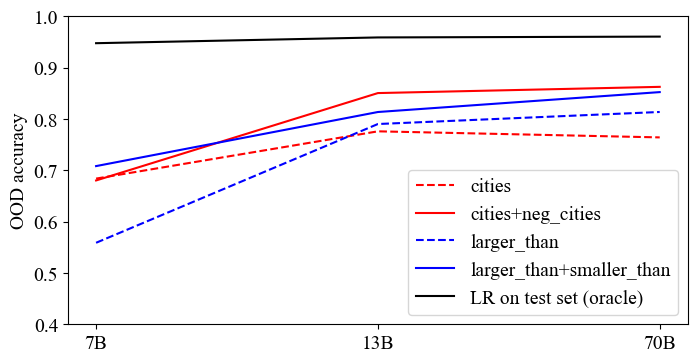

In [8]:
scales = {0 : 7, 1 : 13, 2 : 70}

fig = plt.figure(figsize=(8, 4))

font = {'family' : 'Times New Roman',
        'size'   : 14}

plt.rc('font', **font)

def get_accs(full_accs, model, probe_type, medley, drop=[]):
    accs = full_accs[model][probe_type][to_str(medley)].copy()
    for d in drop:
        del accs[d]
    return accs

def get_avg(full_accs, model, probe_type, medley, drop=[]):
    accs = get_accs(full_accs, model, probe_type, medley, drop=drop)
    return sum(accs.values()) / len(accs)


plt.plot(
    [get_avg(accssss, f'llama-2-{scales[i]}b', 'LRProbe', ['cities'], ['cities', 'neg_cities']) for i in range(len(scales))], 'r--', label='cities'
)
plt.plot(
    [get_avg(accssss, f'llama-2-{scales[i]}b', 'LRProbe', ['cities', 'neg_cities'], ['cities', 'neg_cities']) for i in range(len(scales))], 'r-', label='cities+neg_cities'
)
plt.plot(
    [get_avg(accssss, f'llama-2-{scales[i]}b', 'LRProbe', ['larger_than'], ['larger_than', 'smaller_than']) for i in range(len(scales))], 'b--', label='larger_than'
)
plt.plot(
    [get_avg(accssss, f'llama-2-{scales[i]}b', 'LRProbe', ['larger_than', 'smaller_than'], ['larger_than', 'smaller_than']) for i in range(len(scales))], 'b-', label='larger_than+smaller_than'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['oracle'] for i in range(len(scales))], 'k-', label='LR on test set (oracle)'
)
# plt.plot(
#     [averagesss[f'llama-2-{scales[i]}b']['LRProbe']['likely'] for i in range(len(scales))], '-', color='gray', label='likely'
# )

# set x ticks
plt.xticks(range(len(scales)), [f'{scales[i]}B' for i in range(len(scales))])

plt.ylabel('OOD accuracy')

plt.ylim(0.4, 1)
plt.legend()
plt.savefig('junk/duplicate_generalization.pdf', bbox_inches='tight')

plt.show()




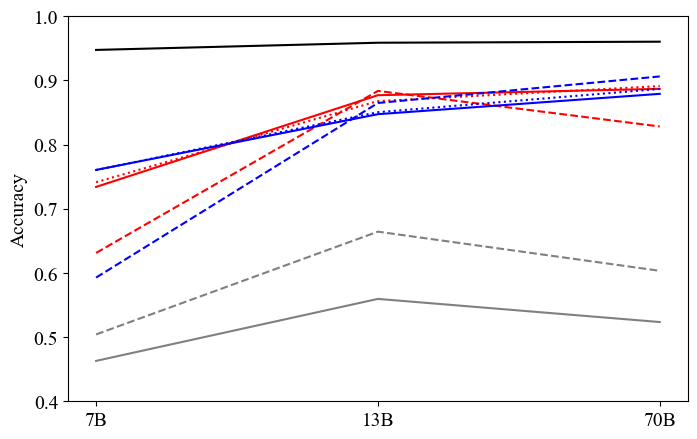

In [6]:
plt.figure(figsize=(8, 5))


plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['LRProbe']['cities+neg_cities'] for i in range(3)], 'r-',
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['MMProbe']['cities+neg_cities'] for i in range(3)], 'r--'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['CCSProbe']['cities+neg_cities'] for i in range(3)], 'r:'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['LRProbe']['larger_than+smaller_than'] for i in range(3)], 'b-'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['MMProbe']['larger_than+smaller_than'] for i in range(3)], 'b--'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['CCSProbe']['larger_than+smaller_than'] for i in range(3)], 'b:'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['oracle'] for i in range(3)], 'k-'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['LRProbe']['likely'] for i in range(3)], '-', color='gray'
)
plt.plot(
    [averagesss[f'llama-2-{scales[i]}b']['MMProbe']['likely'] for i in range(3)], '--', color='gray'

)
plt.ylim(0.4, 1)

plt.xticks(range(len(scales)), [f'{scales[i]}B' for i in range(len(scales))])

plt.ylabel('Accuracy')

plt.ylim(0.4, 1)

plt.show()

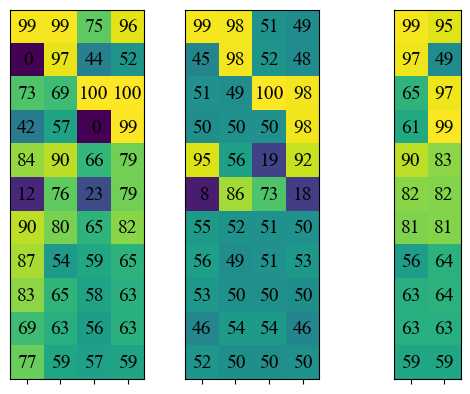

In [16]:
fig, axes = plt.subplots(1, 3)

model = 'llama-2-7b'

def make_axis(ax, model, probe_type, medlies):
    grid = [ [None for _ in medlies] for _ in val_datasets]
    for i, dataset in enumerate(val_datasets):
        for j, medley in enumerate(medlies):
            grid[i][j] = get_accs(accssss, model, probe_type, medley)[dataset]
    ax.imshow(grid, vmin=0, vmax=1)

    for i in range(len(grid)):
        for j in range(len(grid[0])):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d}', ha='center', va='center')

    ax.set_xticks(range(len(medlies)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

make_axis(axes[0], model, 'LRProbe', [['cities'], ['cities', 'neg_cities'], ['larger_than'], ['larger_than', 'smaller_than']])

make_axis(axes[1], model, 'MMProbe', [['cities'], ['cities', 'neg_cities'], ['larger_than'], ['larger_than', 'smaller_than']])

make_axis(axes[2], model, 'CCSProbe', [['cities', 'neg_cities'], ['larger_than', 'smaller_than']])

# grid = [ [None for _ in range(4)] for _ in val_datasets]
# for i, dataset in enumerate(val_datasets):
#     grid[i][0] = get_accs(accssss, model, 'LRProbe', ['likely'])[dataset]
#     grid[i][1] = get_accs(accssss, model, 'MMProbe', ['likely'])[dataset]
#     grid[i][2] = accssss[model]['few_shot'][dataset]
#     grid[i][3] = accssss[model]['oracle'][dataset]
# axes[2].imshow(grid, vmin=0, vmax=1)
# axes[2].set_xticks(range(4))
# axes[2].set_xticklabels([])
# axes[2].set_yticks([])
# axes[2].set_yticklabels([])

# for i in range(len(grid)):
#     for j in range(len(grid[0])):
#         axes[2].text(j, i, f'{round(grid[i][j] * 100):2d}', ha='center', va='center')

# axes[0].set_yticks(range(len(val_datasets)))
# axes[0].set_yticklabels([])

# add colorbar
# plt.colorbar(axes[0].images[0])

fig.savefig('junk/llama-2-7b_generalization.pdf')
fig.show()
        